## Melanoma Detection Assignment

### Problem statement
- To build a CNN based model which can accurately detect melanoma.
- Melanoma is:
    - a type of cancer that can be deadly if not detected early.
    - It accounts for 75% of skin cancer deaths.
- A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### DataSet

- The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC).
- All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
- The data set contains the following diseases:
    - Actinic keratosis
    - Basal cell carcinoma
    - Dermatofibroma
    - Melanoma
    - Nevus
    - Pigmented benign keratosis
    - Seborrheic keratosis
    - Squamous cell carcinoma
    - Vascular lesion

### Importing all the important libraries used in this file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img
from collections import defaultdict
import os
from glob import glob
import pathlib

In [2]:
#Code for google.colab

from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q /content/gdrive/MyDrive/CNN_assignment.zip -d /content/CNN_assignment/

data_dir_train = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
#Code for local Drive

#data_dir_train = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Train')
#data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
# Setting parameters

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Code for train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Code for validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List of all the classes of skin cancer

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

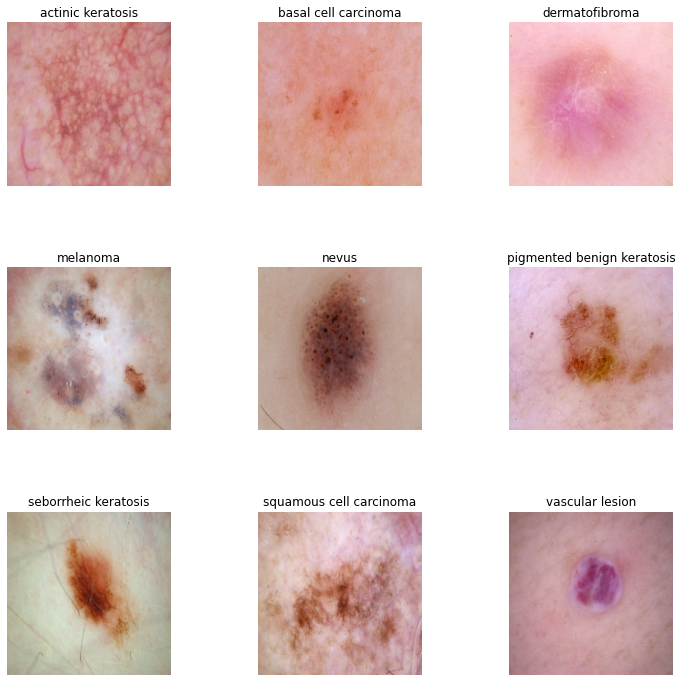

In [9]:
# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the class names and find an instance for each class
for i, class_name in enumerate(class_names):
    # Find the first image of this class
    #print(i, class_name)
    found_image = False
    for images, labels in train_ds:
        if tf.reduce_any(labels == i):
            image = images[labels == i][0]
            found_image = True
            break
    if not found_image:
        #print(f"No images found for class {class_name}")
        continue
    # Plot the image on a subplot
    row = i // 3
    col = i % 3
    axes[row][col].imshow(image.numpy().astype('uint8'))
    axes[row][col].set_title(class_name)
    axes[row][col].axis('off')

# Show the plot
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model

In [10]:
# Define the input shape of images
input_shape = (180, 180, 3)

# Create a Sequential model
model = Sequential()

# Add a Rescaling layer to normalize the pixel values
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape))

# Add the convolutional layers
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Add the flatten layer to convert the 2D output to 1D
model.add(layers.Flatten())

# Add the dense layers
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 235ms/step - loss: 2.8031 - accuracy: 0.2360 - val_loss: 1.8801 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 14s 231ms/step - loss: 1.7195 - accuracy: 0.3873 - val_loss: 1.6724 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 14s 228ms/step - loss: 1.5064 - accuracy: 0.4883 - val_loss: 1.4545 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 16s 247ms/step - loss: 1.3847 - accuracy: 0.5195 - val_loss: 1.5540 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 14s 224ms/step - loss: 1.2720 - accuracy: 0.5608 - val_loss: 1.6198 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 14s 225ms/step - loss: 1.1686 - accuracy: 0.5910 - val_loss: 1.4516 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 14s 226ms/step - loss: 1.0856 - accuracy: 0.6211 - val_loss: 1.3730 - val_accuracy: 0.5459

### Visualizing training results

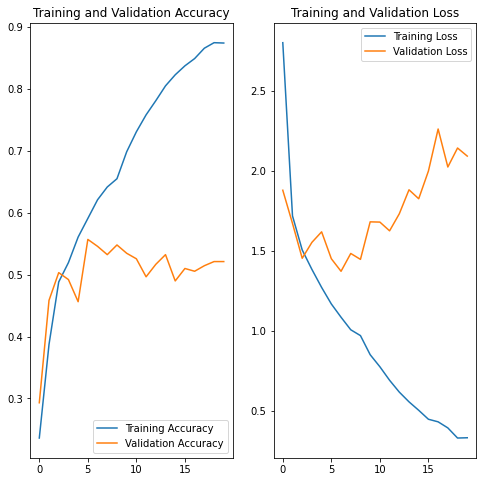

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

<font color="green"><b>1. Bases of the accuracy of model in training and validation dataset, It seems the case of Overfitting. The model performs well in the training dataset and not performs well in the validation dataset.</b></font>

In [15]:
#Data augumentation strategy. 

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,  # reduce the rotation range to avoid overfitting
    zoom_range=0.2,  # reduce the zoom range to avoid overfitting
    width_shift_range=0.1,  # randomly shift images horizontally up to 10% of the width
    height_shift_range=0.1,  # randomly shift images vertically up to 10% of the height
    shear_range=0.1,  # randomly apply shear transformation with intensity up to 10%
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(validation_split=0.2)    

# Load the training data using the data augmentation strategy
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # 80% of the data will be used for training

# Load the validation data using the data augmentation strategy
validation_generator = val_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # 20% of the data will be used for validation

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


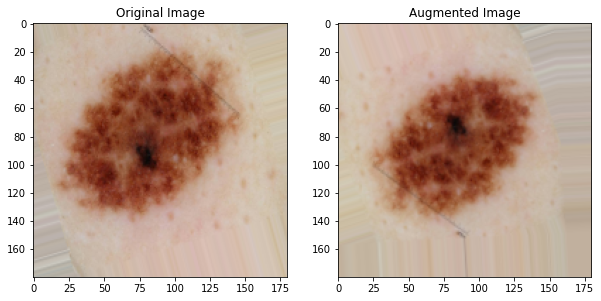

In [16]:
image, label = train_generator.next()
# Plot the original and augmented images
image = image.astype('float32') / 255.0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image[1])
axs[0].set_title('Original Image')
axs[1].imshow(train_datagen.random_transform(image[1]))
axs[1].set_title('Augmented Image')
plt.show()

### Create the model, compile and train the model

In [17]:
# Create a Sequential model
model = Sequential()

# Define the input shape of images
input_shape = (180, 180, 3)

# Add a Rescaling layer to normalize the pixel values
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape))

# Add the convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) # Add a dropout layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5)) # Add a dropout layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) # Add a dropout layer

# Add the flatten layer to convert the 2D output to 1D
model.add(Flatten())

# Add the dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # Add a dropout layer after the dense layer
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)       

### Compiling the model

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [19]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
57/57 [==============================] - 54s 902ms/step - loss: 2.2669 - accuracy: 0.1911 - val_loss: 2.0180 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 51s 891ms/step - loss: 2.0402 - accuracy: 0.1950 - val_loss: 2.0390 - val_accuracy: 0.1959
Epoch 3/20
57/57 [==============================] - 50s 885ms/step - loss: 2.0038 - accuracy: 0.2123 - val_loss: 1.8360 - val_accuracy: 0.3221
Epoch 4/20
57/57 [==============================] - 51s 889ms/step - loss: 1.9274 - accuracy: 0.2641 - val_loss: 1.9171 - val_accuracy: 0.2995
Epoch 5/20
57/57 [==============================] - 49s 864ms/step - loss: 1.8687 - accuracy: 0.3031 - val_loss: 1.7923 - val_accuracy: 0.3243
Epoch 6/20
57/57 [==============================] - 51s 897ms/step - loss: 1.7643 - accuracy: 0.3733 - val_loss: 1.7339 - val_accuracy: 0.3198
Epoch 7/20
57/57 [==============================] - 51s 891ms/step - loss: 1.7011 - accuracy: 0.3900 - val_loss: 1.6810 - val_accuracy: 0.3739

### Visualizing the results

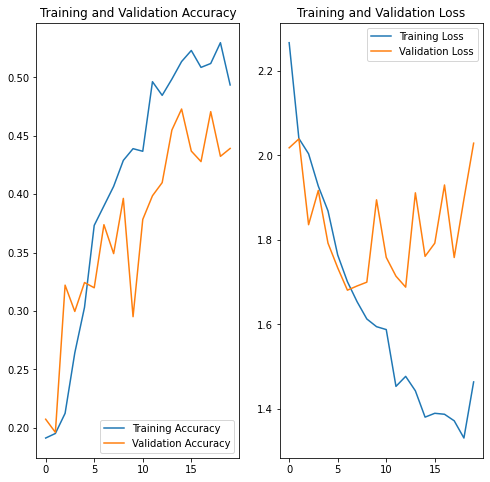

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings

<b><font color="green">1. There is some evidence of overfitting, as the training accuracy is slighlty higher than the validation accuracy.
</font></b>

<b><font color="green">2. Compared to the previous model run, there is some improvement in the validation accuracies, some evidence of overfitting is still there and model accuracy is low signifies underfitting also.</font></b>

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
class_counts = defaultdict(int)

for class_name in os.listdir(data_dir_train):
    class_dir = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

original_df = pd.DataFrame({'count': class_counts})
print(original_df)

                            count
actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139


#### Findings
#### - Which class has the least number of samples?
<b><font color="green">seborrheic keratosis: 77</font></b>

#### - Which classes dominate the data in terms proportionate number of samples?
<b><font color="green">pigmented benign keratosis: 462</font></b>

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [22]:
!pip install Augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [23]:
path_to_training_dataset=data_dir_train

for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F635081E130>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635804E370>: 100%|██████████| 500/500 [00:26<00:00, 18.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63402063D0>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F6340273AF0>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F63506F1220>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63402732E0>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F63402F8B20>: 100%|██████████| 500/500 [00:46<00:00, 10.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6350634580>: 100%|██████████| 500/500 [00:19<00:00, 25.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63508CA2E0>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [25]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df['Label'].value_counts()

melanoma                      500
nevus                         500
dermatofibroma                500
squamous cell carcinoma       500
basal cell carcinoma          500
pigmented benign keratosis    500
vascular lesion               500
seborrheic keratosis          500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [26]:
# Count the number of images in the original training data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in the original training data:", image_count_train)

# Get the path of all augmented images
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Print the number of augmented images
print("Number of augmented images:", len(path_list))

# Print the distribution of images in each class
for class_dir in data_dir_train.glob('*'):
    if class_dir.is_dir():
        class_name = os.path.basename(class_dir)
        class_count = len(list(class_dir.glob('output/*.jpg'))) + len(list(class_dir.glob('./*.jpg')))
        print("Number of images in", class_name, ":", class_count)

Number of images in the original training data: 2239
Number of augmented images: 4500
Number of images in melanoma : 938
Number of images in nevus : 857
Number of images in dermatofibroma : 595
Number of images in squamous cell carcinoma : 681
Number of images in basal cell carcinoma : 876
Number of images in pigmented benign keratosis : 962
Number of images in vascular lesion : 639
Number of images in seborrheic keratosis : 577
Number of images in actinic keratosis : 614


#### **Train the model on the data created using Augmentor**

In [27]:
batch_size = 32
img_height = 180
img_width = 180

#### **Create a training dataset**

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Create a validation dataset**

In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Create your model (make sure to include normalization)**

In [31]:
# Define the input shape
input_shape = (180, 180, 3)

# Create the model
model = Sequential()

# Add a Rescaling layer to normalize the pixel values
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape))

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) # Add a dropout layer

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 512 units
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # Add a dropout layer
model.add(Dense(9, activation='softmax'))

#### **Compile your model**

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

#### **Train your model**

In [33]:
epochs = 30
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 48s 88ms/step - loss: 1.9437 - accuracy: 0.2643 - val_loss: 1.5948 - val_accuracy: 0.3756
Epoch 2/30
169/169 [==============================] - 9s 56ms/step - loss: 1.5741 - accuracy: 0.4026 - val_loss: 1.3848 - val_accuracy: 0.4759
Epoch 3/30
169/169 [==============================] - 9s 56ms/step - loss: 1.4007 - accuracy: 0.4614 - val_loss: 1.3031 - val_accuracy: 0.5219
Epoch 4/30
169/169 [==============================] - 9s 56ms/step - loss: 1.2550 - accuracy: 0.5338 - val_loss: 1.1718 - val_accuracy: 0.5791
Epoch 5/30
169/169 [==============================] - 9s 55ms/step - loss: 1.1522 - accuracy: 0.5688 - val_loss: 1.1176 - val_accuracy: 0.5857
Epoch 6/30
169/169 [==============================] - 9s 55ms/step - loss: 1.0566 - accuracy: 0.6142 - val_loss: 1.0487 - val_accuracy: 0.6110
Epoch 7/30
169/169 [==============================] - 9s 56ms/step - loss: 0.9319 - accuracy: 0.6578 - val_loss: 0.9958 - val_accuracy: 0.616

#### **Visualize the model results**

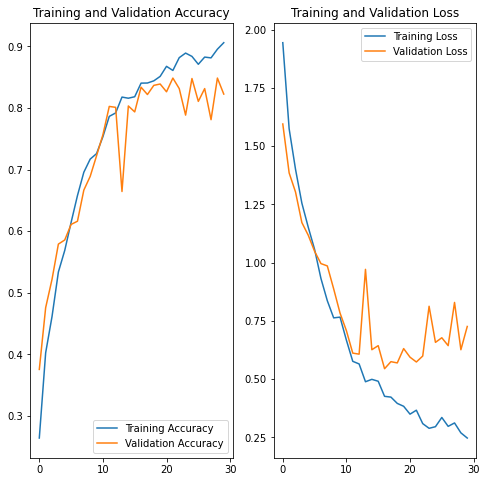

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 196ms/step
Actual Class : basal cell carcinoma
Predictive Class : basal cell carcinoma


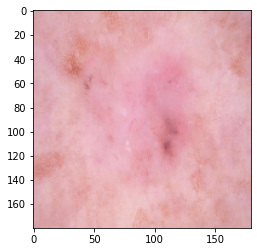

In [35]:
# Model Prediction

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[1] +'\n'+ "Predictive Class : "+pred_class )

#### **Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

<font color="green"><b>Now Model accuracy is good and it seems there is no underfitting and overfitting. Class rebalance has helped as there were more images to learn from.</b></font>

